In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from algorithms.stabilized_ICA import StabilizedICA
import anndata
import scanpy as sc
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

def ismember(A, B):
    dct = {}
    for s,i in enumerate(B):
        dct[i] = s
    return [ dct[a] for a in A ]


def load_signature_file(file):
    sigs = {}
    with open(file,'r',encoding="utf8",errors='ignore') as fin:
        line = fin.readline().strip('\n').strip(' ')
        while line:
            parts = line.split('\t')
            lst = parts[2:]
            lst = [s.split('[')[0] for s in lst if not s=='']
            sigs[parts[0]] = lst
            line = fin.readline().strip('\n').strip(' ')
    return sigs

def calc_scores(anndata,signature_dict):
    matrix = anndata.to_df().to_numpy()
    scores_dic = {}
    for key in signature_dict:
        names = np.array(signature_dict[key])
        inds = np.where(np.isin(anndata.var_names,names))[0]
        matrix_sel = matrix[:,inds]
        scores = np.mean(matrix_sel,axis=1)
        scores_dic[key] = scores
    return scores_dic

def smooth_adata_by_pooling(adata,X_embed,n_neighbours=10):
    adata_pooled = adata.copy()
    nbrs = NearestNeighbors(n_neighbors=n_neighbours).fit(X_embed)
    distances, indices = nbrs.kneighbors(X_embed)    
    adata_pooled.X = smooth_matrix_by_pooling(get_nd_array(adata.X),indices)
    if 'matrix' in adata.layers:
        adata_pooled.layers['matrix'] = smooth_matrix_by_pooling(get_nd_array(adata.layers['matrix']),indices)
    if 'spliced' in adata.layers:
        adata_pooled.layers['spliced'] = smooth_matrix_by_pooling(get_nd_array(adata.layers['spliced']),indices)
    if 'unspliced' in adata.layers:
        adata_pooled.layers['unspliced'] = smooth_matrix_by_pooling(get_nd_array(adata.layers['unspliced']),indices)
    return adata_pooled


def smooth_matrix_by_pooling(matrix,indices):
    matrix_pooled = matrix.copy()
    for i in range(len(indices)):
        matrix_pooled[i,:] = np.mean(matrix[indices[i],:],axis=0)
    return matrix_pooled

def get_nd_array(arr):
    x = None
    if str(type(arr)):
        x = arr
    else:
        x = arr.toarray()
    return x

def preprocessing_without_pooling(adata):
    if Normalize_Totals:
        sc.pp.normalize_total(adata, target_sum=10000)
    if not Already_Log_Transformed:
        sc.pp.log1p(adata)
    if top_variable_genes>0:
        #sc.pp.highly_variable_genes(adata,n_top_genes=top_variable_genes,n_bins=20)
        #ind_genes = np.where(adata.var['highly_variable'])[0]
        vars = np.var(adata.X,axis=0)
        inds = np.flip(np.argsort(vars))
        ind_genes = inds[0:top_variable_genes]
        if 0 in vars[ind_genes]:
            ind_first_zero = np.argwhere(vars[ind_genes]==0)[0][0]
            ind_genes = ind_genes[0:ind_first_zero]
        #print(vars[ind_genes])
        adata = adata[:,ind_genes]
    sc.tl.pca(adata,n_comps=number_of_pcs)
    return adata

# pooling procedure
def pooling_procedure(adata,adata_orig):
    if n_neighbours_for_pooling>0:    
        adata_work = adata_orig.copy()
        preprocessing_without_pooling(adata)
        sc.tl.pca(adata,n_comps=number_of_pcs)
        X_pca = adata.obsm['X_pca']
        adata = smooth_adata_by_pooling(adata_work,X_pca,n_neighbours=n_neighbours_for_pooling)
    return adata

def preprocessing_dataset(adata):
    adata = preprocessing_without_pooling(adata)    
    sc.tl.pca(adata,n_comps=number_of_pcs)
    display(adata)
    return adata

def calc_weighted_scores(anndata,signature_dict):
    matrix = anndata.to_df().to_numpy()
    scores_dic = {}
    for key in signature_dict:
        names_weights = signature_dict[key]
        names = names_weights[0]
        weights = np.array(names_weights[1])
        inds = np.where(np.isin(anndata.var_names,names))[0]
        sel_names = anndata.var_names[inds]
        ind_in_names = ismember(sel_names,names)
        names1 = np.array(names)[ind_in_names]
        weights1 = np.array(weights)[ind_in_names]
        inds = ismember(names1,anndata.var_names)
        matrix_sel = matrix[:,inds]
        gene_means = np.mean(matrix_sel,axis=0)
        meanmat = np.outer(np.ones(matrix_sel.shape[0]),gene_means)
        matrix_sel = matrix_sel-meanmat
        scores = np.matmul(matrix_sel,weights1)
        scores_dic[key] = scores
    return scores_dic

def load_weighted_signature_file(file):
    sigs = {}
    with open(file,'r',encoding="utf8",errors='ignore') as fin:
        line = fin.readline().strip('\n').strip(' ')
        while line:
            parts = line.split('\t')
            lst = parts[2:]
            lst1 = [s.split('[')[0] for s in lst if not s=='']
            weights = [float(s.split('[')[1].split(']')[0]) for s in lst if not s=='']
            #print(lst1,weights)
            sigs[parts[0]] = (lst1,weights)
            #sigs[parts[0]+'_W'] = weights
            line = fin.readline().strip('\n').strip(' ')
    return sigs




/home/zinovyev/.local/lib/python3.7/site-packages/numba/errors.py:137: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [26]:
folder = '../Broad_CellLine/'
cell_line = 'JHU011_UPPER_AERODIGESTIVE_TRACT'
##cell_line = 'SCC25_UPPER_AERODIGESTIVE_TRACT'
suffix = '_raw'
Normalize_Totals = False
division_factor = 50

#folder = '../Retinoblastoma/Y79/'
#cell_line = 'Y79'
#suffix = ''
#division_factor = 1
#Normalize_Totals = True

#folder = '/mnt/c/Datas/BIODICA_GUI/work/Y79_nufp10k_ICA/'
#cell_line = 'Y79_nufp10k'
#suffix = ''

In [201]:
# This cell is specific to Broad cell line collection
# It extracts a cell line from the large CPM_data.txt file
# This step can be done only once and will create a cell_line+'_raw.txt' 
# file containing the CPM counts that need to be pre-processed in the next cell

# Extracting the cell line data

metadata = pd.read_csv(folder+'metadata_header.txt',delimiter='\t')
display(metadata)
cancer_types = list(metadata['Cancer_type'])
cell_lines = list(metadata['Cell_line'])
cellnames = list(metadata['NAME'])

ind_cell_line = np.where(np.array(cell_lines)==cell_line)[0]
with open(folder+'CPM_data.txt') as fin, open(folder+cell_line+'_raw.txt','w') as fout:
    header = fin.readline()[:-1]
    cells = np.array(header.split('\t'))
    ind_cells = [0]+list(ind_cell_line+1)
    fout.write('\t'.join(cells[ind_cells])+'\n')
    ln = fin.readline()[:-1]
    while ln:
        cells = ln.split('\t')
        selected_vals = np.array(cells)[ind_cells[1:]]
        selected_vals = [str(int(float(s))) for s in selected_vals]
        fout.write(cells[0]+'\t'+'\t'.join(selected_vals)+'\n')
        ln = fin.readline()[:-1]

/home/zinovyev/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,NAME,Cell_line,Pool_ID,Cancer_type,Genes_expressed,Discrete_cluster_minpts5_eps1.8,Discrete_cluster_minpts5_eps1.5,Discrete_cluster_minpts5_eps1.2,CNA_subclone,SkinPig_score,...,EMTII_score,EMTIII_score,IFNResp_score,p53Sen_score,EpiSen_score,StressResp_score,ProtMatu_score,ProtDegra_score,G1/S_score,G2/M_score
0,AAACCTGAGACATAAC-1-18,NCIH2126_LUNG,18,Lung Cancer,4318,NaN,NaN,NaN,NaN,0.166,...,-0.935,-0.935,0.130,0.619,1.869,-0.004,0.805,0.896,0.424,-1.125
1,AACGTTGTCACCCGAG-1-18,NCIH2126_LUNG,18,Lung Cancer,5200,NaN,NaN,NaN,NaN,-0.213,...,-1.027,-1.027,0.066,1.049,1.267,0.252,1.299,1.610,0.624,-0.048
2,AACTGGTAGACACGAC-1-18,NCIH2126_LUNG,18,Lung Cancer,4004,NaN,NaN,NaN,NaN,-0.101,...,-0.677,-0.677,0.304,0.822,2.401,0.141,0.451,1.225,-0.795,0.064
3,AACTGGTAGGGCTTGA-1-18,NCIH2126_LUNG,18,Lung Cancer,4295,NaN,NaN,NaN,NaN,-0.014,...,-0.735,-0.735,0.094,0.834,2.282,0.150,0.267,0.892,-0.238,1.118
4,AACTGGTAGTACTTGC-1-18,NCIH2126_LUNG,18,Lung Cancer,4842,NaN,NaN,NaN,NaN,0.006,...,-0.821,-0.821,0.034,0.960,1.400,-0.012,-0.276,-0.428,0.267,0.791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53508,c4722,JHU006_UPPER_AERODIGESTIVE_TRACT,custom,Head and Neck Cancer,3343,NaN,NaN,NaN,NaN,0.018,...,-0.505,-0.505,1.657,1.583,3.850,0.539,0.473,0.544,-1.079,-1.349
53509,c4724,JHU006_UPPER_AERODIGESTIVE_TRACT,custom,Head and Neck Cancer,6977,NaN,NaN,NaN,NaN,-0.098,...,-0.876,-0.876,0.669,1.086,3.046,0.799,0.490,1.319,-0.370,0.057
53510,c4731,JHU006_UPPER_AERODIGESTIVE_TRACT,custom,Head and Neck Cancer,6638,NaN,NaN,NaN,NaN,-0.112,...,-0.112,-0.112,0.610,0.693,2.289,0.650,0.729,1.143,-0.508,0.501
53511,c4735,JHU006_UPPER_AERODIGESTIVE_TRACT,custom,Head and Neck Cancer,4052,NaN,NaN,NaN,NaN,-0.244,...,1.981,1.981,0.523,-0.309,0.267,0.822,1.049,0.777,0.296,-0.936


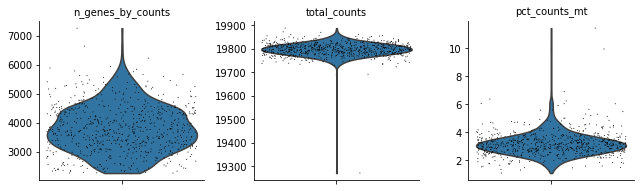

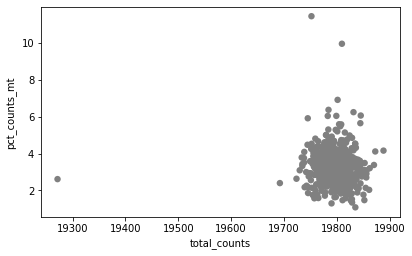

717 samples pass the count filter
717  samples pass the mt filter
Samples selected 717


/home/zinovyev/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/zinovyev/anaconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/zinovyev/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


AnnData object with n_obs × n_vars = 717 × 10000
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [27]:
# Preprocessing the file
# It is normally should be done only once and result in cell_line+'_proc.txt' 
# file. Pay attention that you might want to change the dataset-specific 
# thresholds on the total counts and mt percentage.
# If this is already done then one can open the "_proc.txt" file right away 
# in the next cell

top_variable_genes = 10000 # if negative then no selection of genes
Normalize_Totals = True
Already_Log_Transformed = False
n_neighbours_for_pooling = 10
number_of_pcs = 20


df = pd.read_csv(folder+cell_line+suffix+'.txt',delimiter='\t')
adata_k = sc.AnnData(X=df[df.columns[1:]].to_numpy().transpose())
adata_k.obs_names = list(df.columns[1:])
adata_k.var_names = list(df[df.columns[0]])
adata_k.X = adata_k.X/division_factor

# Quality control
adata_k.var['mt'] = adata_k.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata_k, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata_k, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)
sc.pl.scatter(adata_k, x='total_counts', y='pct_counts_mt')
inds1 = np.where((adata_k.obs['total_counts']>10000) & (adata_k.obs['total_counts']<40000))
inds2 = np.where(adata_k.obs['pct_counts_mt']<20)
print(len(inds1[0]),'samples pass the count filter')
print(len(inds2[0]),' samples pass the mt filter')
ind_samples = np.intersect1d(inds1[0],inds2[0])
print('Samples selected',len(ind_samples))
adata_k = adata_k[ind_samples,:]


if n_neighbours_for_pooling>0:
    adata_k1 = pooling_procedure(adata_k,adata_k)
adata_k1 = preprocessing_dataset(adata_k1)
dc = {'GENE':list(adata_k1.var_names)}
for j,s in enumerate(adata_k1.obs_names):
    dc[s] = adata_k1.X[j,:]
pd.DataFrame(data=dc).to_csv(folder+cell_line+'_proc.txt',sep='\t',index=False)

In [5]:
#file = folder+cell_line+'.txt'
#df = pd.read_csv(file , sep='\t', index_col=0)
#df = df.transpose()
#display(df)

In [28]:
file = folder+cell_line+'_proc.txt'
df = pd.read_csv(file , sep='\t', index_col=0)
df = df.transpose()
display(df)

GENE,UBE2C,CKS2,HMGB2,CENPF,HIST1H4C,SMC4,TUBB4B,KPNA2,CCNB1,CDKN3,...,SEPT1,LIN9,SLC25A35,ICA1L,ZNF395,NDRG2,ZFP1,ACVR1,TMPO-AS1,ZNF532
c9,1.381110,1.256922,0.979803,1.134126,0.803593,1.599223,1.107447,1.107781,0.862865,1.746620,...,0.000000,0.000000,0.016035,0.043493,0.047354,0.030838,0.038645,0.000000,0.000000,0.024943
c15,0.649269,0.559327,0.233194,0.186521,0.842089,0.800324,1.086757,0.467475,0.203147,0.725448,...,0.033767,0.000000,0.058840,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.082371
c21,1.974398,1.603580,1.786462,0.820389,2.370820,1.903614,2.068349,0.479005,0.376248,1.104005,...,0.034761,0.077749,0.000000,0.000000,0.000000,0.074940,0.000000,0.022979,0.034761,0.000000
c24,2.856598,2.351098,1.919159,1.474010,2.505249,2.245117,2.799385,1.746836,1.484136,1.529355,...,0.000000,0.030833,0.053110,0.000000,0.000000,0.000000,0.032790,0.000000,0.000000,0.064539
c30,0.387086,0.504710,0.337167,0.167040,0.750033,0.457902,1.122832,0.356445,0.000000,0.324105,...,0.080502,0.000000,0.000000,0.041545,0.103532,0.000000,0.000000,0.040576,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c4721,2.299436,1.783839,1.934964,1.141749,2.538977,2.088998,2.406067,1.064299,0.702417,1.178801,...,0.000000,0.039626,0.000000,0.031825,0.026919,0.000000,0.000000,0.038654,0.080543,0.000000
c4728,0.238011,0.729909,0.316836,0.081451,0.413559,0.716183,1.525723,0.365666,0.024942,0.110814,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.148961,0.000000,0.032794,0.000000,0.060751
c4758,2.697994,2.178719,2.064455,1.695720,2.540043,2.326467,2.331782,1.522021,1.271402,1.711904,...,0.072118,0.073058,0.000000,0.093514,0.072118,0.063620,0.000000,0.000000,0.000000,0.000000
c4769,3.020840,2.506931,2.050431,1.897617,2.541892,2.360680,2.542846,1.870596,1.579056,1.685463,...,0.000000,0.000000,0.033774,0.000000,0.000000,0.067390,0.000000,0.000000,0.000000,0.000000


running time (min): 02:32.34


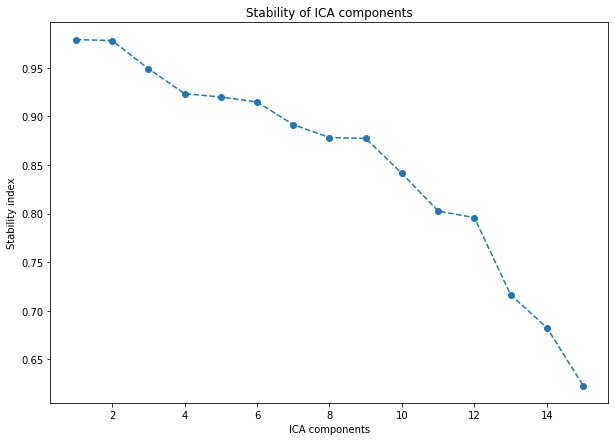

In [29]:
start = time.time()

X = df.values
#Uncomment next line if you want to subsample the dataset
#X = X[np.random.choice(X.shape[0],1000),:]
mn = np.mean(X,axis=0)
X = X - mn


sICA = StabilizedICA(n_components = 15 , max_iter = 2000, n_jobs = -1)
sICA.fit(X, n_runs = 100, plot = True, normalize=True)

end = time.time()

minutes, seconds = divmod(end - start, 60)
print("running time (min): " + "{:0>2}:{:05.2f}".format(int(minutes),seconds))

In [30]:
Metagenes = pd.DataFrame(sICA.S_ , columns = df.columns , index = ['IC'+ str(i+1) for i in range(sICA.S_.shape[0])])
display(Metagenes.head())
sfile = file[:-4]+"_PT_S.xls"
Metagenes.transpose().to_csv(sfile,sep='\t')

#sfile = 'Y79_nufp10k_ica_S.xls'
#temp = pd.read_csv(sfile,delimiter='\t',index_col=False).transpose()
#Xtemp = temp.to_numpy()[1:-1,:]
#Metagenes = pd.DataFrame(Xtemp, columns = list(temp.to_numpy()[0,:]), index = ['IC'+ str(i+1) for i in range(Xtemp.shape[0])])
#display(Metagenes.head())

GENE,UBE2C,CKS2,HMGB2,CENPF,HIST1H4C,SMC4,TUBB4B,KPNA2,CCNB1,CDKN3,...,SEPT1,LIN9,SLC25A35,ICA1L,ZNF395,NDRG2,ZFP1,ACVR1,TMPO-AS1,ZNF532
IC1,0.083707,-2.885183,-0.101249,4.627967,-0.881895,2.746565,-2.982715,-1.354843,-1.946431,-0.357253,...,-0.287227,0.077162,-0.541760,0.009974,-0.294289,-0.354438,-0.344723,-0.121888,-0.179448,-0.459336
IC2,9.267478,1.788512,9.429220,-0.227811,15.169507,10.481203,5.291735,-2.854700,-4.510893,-1.723644,...,-0.210257,0.054880,-0.105042,-0.399733,-0.331580,0.004735,-0.257602,-0.193746,0.133354,-0.289825
IC3,15.205176,20.963954,15.452241,14.884999,3.489768,10.365091,12.240603,14.330133,15.575504,8.857244,...,-0.005601,-0.143814,-0.105351,-0.176336,-0.078163,-0.016738,0.033757,-0.059695,-0.028489,0.063001
IC4,-2.066348,-1.994466,0.105127,-1.904234,-0.572350,-0.289385,5.756708,4.895098,4.322582,0.023987,...,-0.078618,0.038770,0.301395,-0.333801,-0.177776,-0.109343,0.135694,-0.143883,-0.369855,-0.083120
IC5,-0.625002,-0.701615,-1.726384,0.771678,-2.434164,-1.206670,0.513730,0.580808,-2.267041,-1.718611,...,0.143906,0.177715,-0.155561,-0.164680,-0.176863,0.012486,-0.587996,0.009898,-0.259275,-0.100443


G2M -> IC3
G2M_INH -> IC7
G1S -> IC2
HISTONES -> IC10


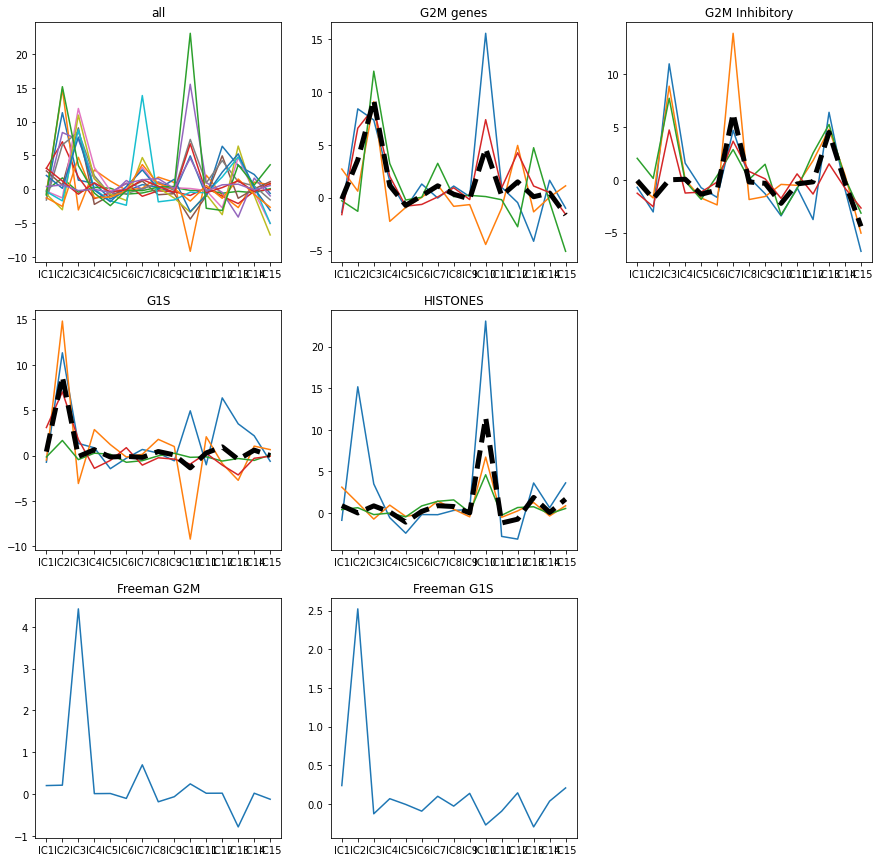

In [35]:
freeman_G1S = ['ADAMTS1','ASF1B','ATAD2','BARD1','BLM','BRCA1','BRIP1','C17orf75','C9orf40','CACYBP','CASP8AP2','CCDC15','CCNE1','CCNE2','CCP110','CDC25A','CDC45','CDC6','CDC7','CDK2','CDT1','CENPJ','CENPQ','CENPU','CEP57','CHAF1A','CHAF1B','CHEK1','CLSPN','CREBZF','CRYL1','CSE1L','DCLRE1B','DCTPP1','DEK','DERA','DHFR','DNA2','DNAJC9','DNMT1','DONSON','DSCC1','DSN1','DTL','E2F8','EED','EFCAB11','ENDOD1','ETAA1','EXO1','EYA2','EZH2','FAM111A','FANCE','FANCG','FANCI','FANCL','FBXO5','FEN1','GGH','GINS1','GINS2','GINS3','GLMN','GMNN','GMPS','GPD2','HADH','HELLS','HSF2','ITGB3BP','KIAA0101','KNTC1','LIG1','MCM10','MCM2','MCM3','MCM4','MCM5','MCM6','MCM7','MCMBP','METTL9','MMD','MNS1','MPP1','MRE11A','MSH2','MSH6','MYO19','NASP','NPAT','NSMCE4A','ORC1','OSGEPL1','PAK1','PAQR4','PARP2','PASK','PAXIP1','PBX3','PCNA','PKMYT1','PMS1','POLA1','POLA2','POLD3','POLE2','PRIM1','PRPS2','PSMC3IP','RAB23','RAD51','RAD51AP1','RAD54L','RBBP8','RBL1','RDX','RFC2','RFC3','RFC4','RMI1','RNASEH2A','RPA1','RRM1','RRM2','SLBP','SLC25A40','SMC2','SMC3','SSX2IP','SUPT16H','TEX30','TFDP1','THAP10','THEM6','TIMELESS','TIPIN','TMEM106C','TMEM38B','TRIM45','TRIP13','TSPYL4','TTI1','TUBGCP5','TYMS','UBR7','UNG','USP1','WDHD1','WDR76','WRB','YEATS4','ZBTB14','ZWINT']
freeman_G2M = ['ADGRE5','ARHGAP11A','ARHGDIB','ARL6IP1','ASPM','AURKA','AURKB','BIRC5','BORA','BRD8','BUB1','BUB1B','BUB3','CCNA2','CCNB1','CCNB2','CCNF','CDC20','CDC25B','CDC25C','CDC27','CDCA3','CDCA8','CDK1','CDKN1B','CDKN3','CENPE','CENPF','CENPI','CENPN','CEP55','CEP70','CEP85','CKAP2','CKAP5','CKS1B','CKS2','CTCF','DBF4','DBF4B','DCAF7','DEPDC1','DLGAP5','ECT2','ERCC6L','ESPL1','FAM64A','FOXM1','FZD2','FZD7','FZR1','GPSM2','GTF2E1','GTSE1','H2AFX','HJURP','HMGB2','HMGB3','HMMR','HN1','INCENP','JADE2','KIF11','KIF14','KIF15','KIF18A','KIF18B','KIF20A','KIF20B','KIF22','KIF23','KIF2C','KIF4A','KIF5B','KIFC1','KPNA2','LBR','LMNB2','MAD2L1','MELK','MET','METTL4','MIS18BP1','MKI67','MPHOSPH9','MTMR6','NCAPD2','NCAPG','NCAPG2','NCAPH','NDC1','NDC80','NDE1','NEIL3','NEK2','NRF1','NUSAP1','OIP5','PAFAH2','PARPBP','PBK','PLEKHG3','PLK1','PLK4','PRC1','PRR11','PSRC1','PTTG1','PTTG3P','RACGAP1','RAD21','RASSF1','REEP4','SAP30','SHCBP1','SKA1','SLCO1B3','SOGA1','SPA17','SPAG5','SPC25','SPDL1','STIL','STK17B','TACC3','TAF5','TBC1D2','TBC1D31','TMPO','TOP2A','TPX2','TROAP','TTF2','TTK','TUBB4B','TUBD1','UBE2C','UBE2S','VANGL1','WEE1','WHSC1','XPO1','ZMYM1']
g2m_markers = ['CDK1','MKI67','CCNB2','AURKB']
g1s_markers = ['RRM2','PCNA','MCM10','ORC6']
g2m_inhibitory_markers = ['CDC20','CDKN3','NUF2','UBE2S']
histone_markers = ['HIST1H4C','HIST1H1E','HIST2H2AC']

freeman_G1S = [s for s in freeman_G1S if s in Metagenes]
freeman_G2M = [s for s in freeman_G2M if s in Metagenes]
g2m_markers = [s for s in g2m_markers if s in Metagenes]
g1s_markers = [s for s in g1s_markers if s in Metagenes]
g2m_inhibitory_markers = [s for s in g2m_inhibitory_markers if s in Metagenes]
histone_markers = [s for s in histone_markers if s in Metagenes]

g2m_score = np.mean(Metagenes[g2m_markers],axis=1)
g1s_score = np.mean(Metagenes[g1s_markers],axis=1)
g2m_inhibitory_score = np.mean(Metagenes[g2m_inhibitory_markers],axis=1)
histone_score = np.mean(Metagenes[histone_markers],axis=1)

idx_g2m_signal = np.argmax(g2m_score)
g2m_inhibitory_score[idx_g2m_signal] = 0
idx_g2m_inhibitory_signal = np.argmax(g2m_inhibitory_score)
idx_g1s_signal = np.argmax(g1s_score)
histone_score[idx_g1s_signal] = 0
idx_histone_signal = np.argmax(histone_score)

print('G2M ->','IC'+str(idx_g2m_signal+1))
print('G2M_INH ->','IC'+str(idx_g2m_inhibitory_signal+1))
print('G1S ->','IC'+str(idx_g1s_signal+1))
print('HISTONES ->','IC'+str(idx_histone_signal+1))

fig = plt.figure(figsize=(15,15))

plt.subplot(3,3,1)
plt.plot(Metagenes[g1s_markers+g2m_markers+g2m_inhibitory_markers+histone_markers])
plt.title('all')

plt.subplot(3,3,2)
plt.plot(Metagenes[g2m_markers])
plt.plot(g2m_score,'k--',linewidth=5)
plt.title('G2M genes')

plt.subplot(3,3,3)
plt.plot(Metagenes[g2m_inhibitory_markers])
plt.plot(g2m_inhibitory_score,'k--',linewidth=5)
plt.title('G2M Inhibitory')

plt.subplot(3,3,4)
plt.plot(Metagenes[g1s_markers])
plt.plot(g1s_score,'k--',linewidth=5)
plt.title('G1S')

plt.subplot(3,3,5)
plt.plot(Metagenes[histone_markers])
plt.plot(histone_score,'k--',linewidth=5)
plt.title('HISTONES')

plt.subplot(3,3,7)
plt.plot(np.mean(Metagenes[freeman_G2M],axis=1))
plt.title('Freeman G2M')

plt.subplot(3,3,8)
plt.plot(np.mean(Metagenes[freeman_G1S],axis=1))
plt.title('Freeman G1S')
plt.show()

/home/zinovyev/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


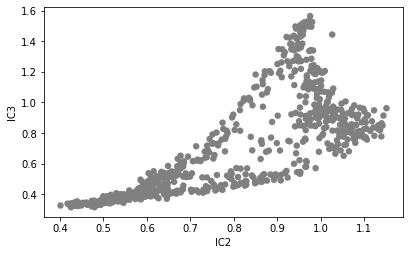

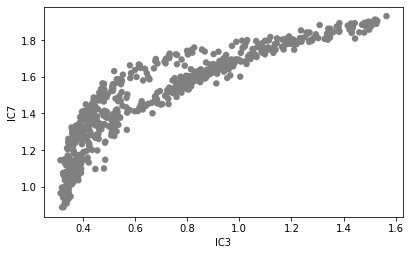

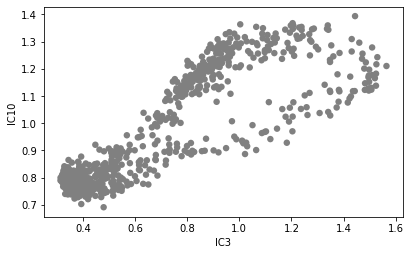

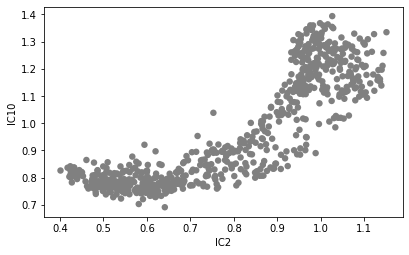

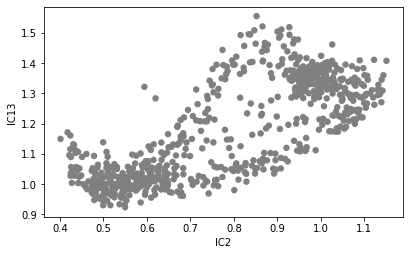

In [36]:
gmtfile = sfile[:-4]+'.gmt'

threshold = 3
dfs = pd.read_csv(sfile,delimiter='\t')
dfs1 = dfs[dfs.columns[1:]]
with open(gmtfile,'w') as fout:
    for s in dfs1.columns:
        fout.write(s+'\tna\t')
        for i in range(dfs[s].shape[0]):
            val = float(dfs[s].iloc[i])
            gn = dfs[dfs.columns[0]].iloc[i]
            if val>threshold:
                fout.write(gn+'\t')
        fout.write('\n')
        
threshold = 2
dfs = pd.read_csv(sfile,delimiter='\t')
dfs1 = dfs[dfs.columns[1:]]
gmtfile_weighted = sfile[:-4]+'_weighted.gmt'
with open(gmtfile_weighted,'w') as fout:
    for s in dfs1.columns:
        fout.write(s+'\tna\t')
        for i in range(dfs[s].shape[0]):
            val = float(dfs[s].iloc[i])
            gn = dfs[dfs.columns[0]].iloc[i]
            if abs(val)>threshold:
                fout.write(gn+'['+str(val)+']'+'\t')
        fout.write('\n')

signature_dict = load_signature_file(gmtfile)

adata = sc.AnnData(X=df.to_numpy())
adata.var_names = list(df.columns)
adata.obs_names = list(df.index)

sc.pp.highly_variable_genes(adata,n_top_genes=2001,n_bins=20)
ind_genes2k = np.where(adata.var['highly_variable'])[0]
adata2k = adata[:,ind_genes2k]
scores_dic = calc_scores(adata2k,signature_dict)
#scores_dic = calc_weighted_scores(adata2k,signature_dict)
for s in scores_dic:
    adata.obs[s] = scores_dic[s]

sc.pl.scatter(adata,x='IC'+str(idx_g1s_signal+1),y='IC'+str(idx_g2m_signal+1))
sc.pl.scatter(adata,x='IC'+str(idx_g2m_signal+1),y='IC'+str(idx_g2m_inhibitory_signal+1))
sc.pl.scatter(adata,x='IC'+str(idx_g2m_signal+1),y='IC'+str(idx_histone_signal+1))
sc.pl.scatter(adata,x='IC'+str(idx_g1s_signal+1),y='IC'+str(idx_histone_signal+1))

sc.pl.scatter(adata,x='IC'+str(idx_g1s_signal+1),y='IC13')
